<a href="https://colab.research.google.com/github/wlsisl/ESAA_/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%BC%80%EB%9D%BC%EC%8A%A4(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH3. 케라스
## 01. 딥러닝 준비

* 텐서플로가 케라스 API를 내제화함
* 직관적이고 사용자 친화적임
* 백엔드 엔진을 쉽게 변경할 수 있다는 장점이 있음

### 1-1 주요 용어
 1) 하이퍼 파라미터
 > 모델을 훈련할 때 사용자가 직접 설정해주는 설정 값

 모델이 훈련하면서 가중치와 편향은 자동 업데이트되고 조정되며 알아서 변하는 값들이지만, 그 외에 학습 속도나 반복 훈련 횟수 등 사용자가 직접 설정해야하는 값들이 많다. 

\

 2) 과소적합 vs 과대적합

 훈련용 데이터를 반복적으로 학습하면서 모델은 사람이 발견하지 못하는 패턴을 발견하므써 사람의 예측 성능을 뛰어 넘는 모델을 생성할 수 있다. 

 but, 예측할 데이터가 모델이 학습한 데이터와 다른 분포를 갖거나, 학습 데이터가 특정 레이블에 편향된 데이터로 이루어져있다면 성능이 떨어짐

  * 과소적합 : 모델이 충분히 학습되지 않은 경우
  * 과대적합 : 지나치게 반복 학습 되어 과하게 적합됨.

\

3) 에포크(epoch)

 딥러닝은 데이터셋을 학습하는 과정을 여러번 반복하면서 최적의 모델 가중치를 찾는 과정이다. 딥러닝 모델이 반복 훈련을 할 때 데이터셋을 전부학습에 사용하는 1회의 훈련 루프를 1epoch라고 한다.

 -> epoch까지 반복학습이 끝나더라도 모델이 과소적합되었다고 판단되면 epoch를 늘려서 다시 학습할 필요가 있음.

\

4) 손실함수(loss function)

> 예측 값과 정답 값의 차이 또는 오차
> 오차: 딥러닝 모델의 출력 값과 실제 값과의 차이

분류나 회귀 모델에 따라 손심함수를 다르게 적용한다.

1. 지도학습 분류문제
* 이진 분류

'binary_crossentropy' 손실 함수 사용하며, 출력층의 활성화 함수(activation function)가 'sigmoid'인 경우

* 다중 분류

'categorical_crossentropy'손실함수 사용, 다중 분류 대상이 되는 클래스가 원핫 벡터인 경우 사용한다. 만약 레이블 값인 경우 'sparse_categorical_crossentropy'손실 함수 사용

  - 다중 분류에서 출력층의 활성함수로 'softmax'를 사용한다.

2. 회귀 모델

평균 제곱 오차 (MSE) 평균 절대값 오차(MAE), 후버 등이 사용된다. 


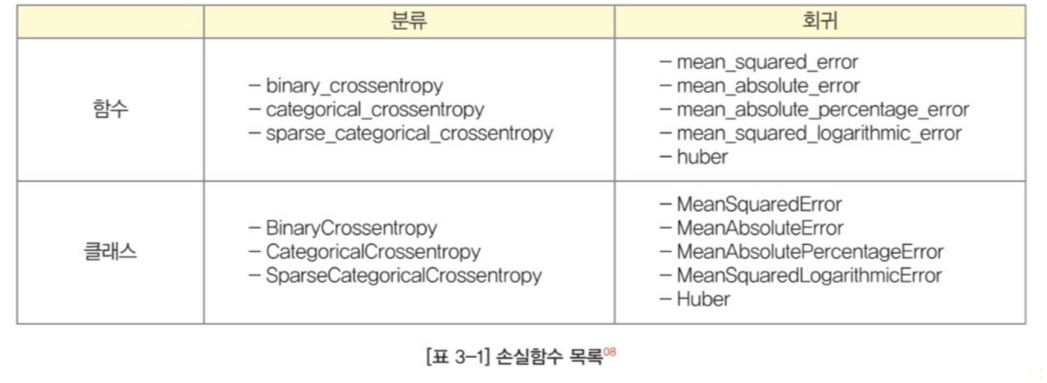

In [1]:
import tensorflow as tf

#클래스
tf.keras.losses.BinaryCrossentropy()

#함수
tf.keras.losses.binary_crossentropy

<function keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

5) 경사하강법

모델 내부의 가중치에 대한 미분 값을 구하고 목적 함수 값이 낮아지는 방향으로 차감하면서 결국 최소 함수 값을 갖도록 하는 방법이다. 

* 가중치에 대한 미분 값이라는 것은 기울기를 구한다는 것.

딥러닝 훈련 프로세스에서 경사하강법 알고리즘을 적용하여 손실함수 값을 최소로 만드는 가중치를 찾을 수 있다. 


<직접 구현>

손실 함수 : Loss = 1/2 시그마 (y-y^ )^2

y= wx + b

단순 선형회귀 수식이 주어졌을 때, 손실함수를 최소로하는 w와 b를 구하는 과정을 경사하강법으로 구현한다. 


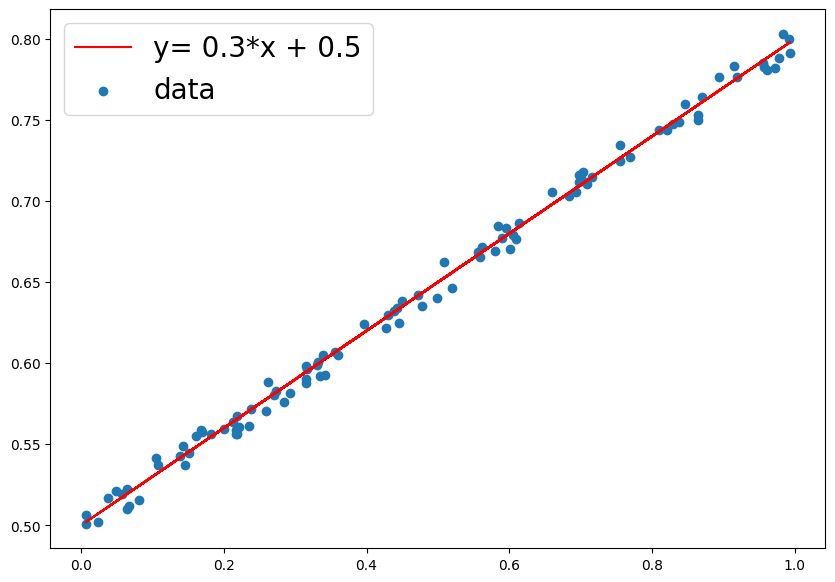

w:0.3, b:0.5


In [5]:
import numpy as np
import matplotlib.pyplot as plt

#샘플에 활용할 데이터셋 만들기

def make_linear(w=0.5, b=0.8, size=50, noise=1.0):
  x=np.random.rand(size)
  y=w*x + b
  noise = np.random.uniform(-abs(noise), abs(noise), size = y.shape)
  yy= y+noise
  plt.figure(figsize=(10,7))
  plt.plot(x,y, color='r', label=f'y= {w}*x + {b}')
  plt.scatter(x, yy, label='data')
  plt.legend(fontsize=20)
  plt.show()
  print(f'w:{w}, b:{b}')
  return x, yy

x,y = make_linear(w=0.3, b=0.5, size=100, noise=0.01)

실제 생성된 y데이터는 y=0.3x + 0.5 식과 완벽히 일치하지 않고 약간의 노이즈가 추가된 것을 확인할 수 있다. 

이제 경사하강법 알고리즘 핵심인 w,b에 대한 그래디언트를 구하는 부분만 구현하면 된다.

------------
그래디언트 손실함수를 w,b 에 대한 각각의 편미분 값을 구한 뒤 학습률 계수를 곱하여 이전의 w,b로부터 차감한다. 

In [6]:
#최대 반복 횟수를 지정하고, 오차가 0.005 이내로 수렴하면 반복문 종료

#최대 반복 횟수
num_epoch=1000

#학습률
learning_rate = 0.005

#에러 기록
errors=[]

#random 한 값으로 w,b를 초기화
w=np.random.uniform(low=0.0, high = 1.0)
b=np.random.uniform(low=0.0, high = 1.0)

for epoch in range(num_epoch):
  y_hat = w * x + b

  #Loss Function
  error = 0.5*((y_hat - y)**2).sum()
  if error < 0.005:
    break
  #Gradient 미분 계산
  w=w-learning_rate *((y_hat - y)*x).sum()
  b=b-learning_rate *(y_hat - y).sum()

  errors.append(error)

  if epoch % 5 == 0 :
    print("{0:2}w = {1:.5f}, b ={2:.5f} error ={3:.5f}".format(epoch, w, b , error))
  
print("----"*15)
print("{0:2}w = {1:.1f}, b ={2:.1f} error ={3:.5f}".format(epoch, w, b , error))

 0w = 0.38454, b =0.58981 error =6.00983
 5w = 0.32651, b =0.48702 error =0.00509
------------------------------------------------------------
 6w = 0.3, b =0.5 error =0.00455


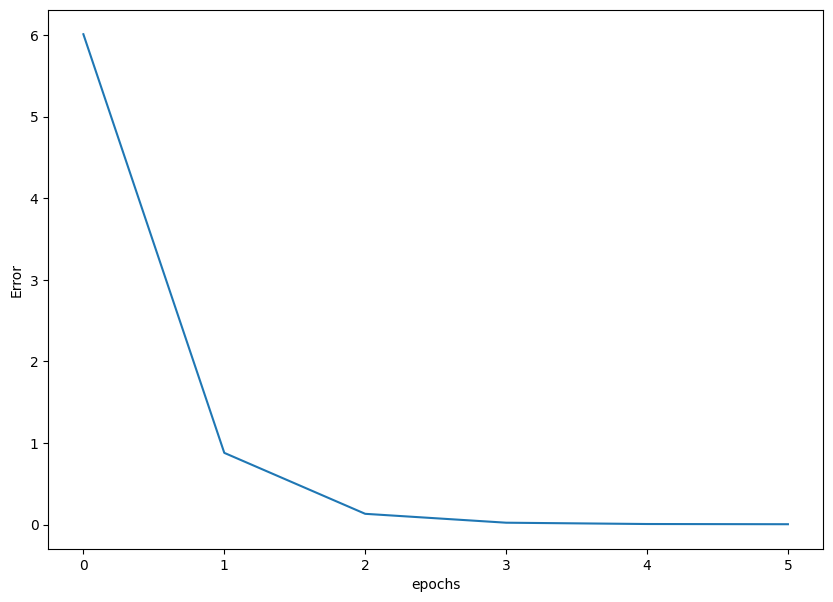

In [7]:
plt.figure(figsize=(10,7))
plt.plot(errors)
plt.xlabel("epochs")
plt.ylabel('Error')
plt.show()

난수 때문에 매번 실행마다 수렴 속도가 차이는 이씾만, 목표하는 오차 범위 안으로 수렴하여 반복문을 종료하게 됨.

## 1-2 딥러닝 프로세스

딥러닝 모델 구축 훈련을 위해서는 다음과 같은 프로세스를 따른다.

> 데이터 로드 -> 전처리 -> 분할 -> 모델 생성&컴파일 -> 훈련-> 검증 -> 하이퍼파라미터 튜닝(반복) -> 예측

1) 데이터 전처리

때에 따라서는 배열의 차원을 변경하거나 스케일을 조정할 수 있다. 

2) 모델 생성

순차적인 구조의 모델은 Sequential API 로 구현

다중 입력 및 출력을 가지고 복잡한 구조를 갖는 모델은 Functional API, Model Subclassing

3) 모델 컴파일

딥러닝 모델의 구조를 정의하고 생성한 뒤에는 생성된 모델 훈련에 사용할 손실함수, 옵티마이저, 평가지표등을 정의

compile() 메소드를 적용하고 여러가지 속성 값을 설정

4) 모델 훈련

fit()함수에 모델 훈련에 필요한 정보를 매개변수로 전달한다.

5) 모델 검증

훈련이 완료된 모델을 검증하는 단계. 모델을 훈련할 때 사용하지 않은 검증 데이터셋을 모델에 입력하고 모델의 예측값을 정답과 비교하여 평가지표를 계산한다. 

6) 모델 예측

## 2. 단순 신경망 훈련

## 2-1) 선형회귀

텐서플로 케라스를 활용하여 단순 선형 회귀 모델을 직접 만들고 딥러닝을 학습한다. 

모델의 기울기 a와 절편 b를 업데이트하면서 종속변수 Y에 가장 근사한 1차 함수식을 완성해 나간다. 

* 딥러닝에서는 기울기 a대신 가중치를 의미하는 w를 더 많이 사용한다. 

## 2-2) 뉴런 

뉴런은 인공 신경망 모델을 구성한느 하나의 신경을 의미한다. 뉴런은 노드라고도 불리며 같은 의미를 가진다. 신경망은 여러 개의 레이어를 가지며, 1개의 레이어는 1개 이상의 뉴런으로 구성된다.  

* 뉴런의 내부에는 가중치가 존재, 모델이 훈련을 진행하면서 오차 역전파를 통해 뉴런의 가중치가 업데이트 된다. 

> 역전파 알고리즘: 신경망 모델의 파라미터들에 대한 그래디언트를 계산하는 방법을 의미한다. 역전파는 신경망을 구성한느 각 레이어와 관련된 손실함수를 미분한 결과인 그래디언트를 출력층에서 입력층 순으로 역으로 계산하고 저장한다. 

## 2-3) Dense레이어

Dense 레이어는 심층 신경망 모델을 구성하는 가장 기본 레이어이다. 각 레이어와 레이어사이에 모든 뉴런이 서로 연결되어 있어 완전 연결층이라고 부르기도 한다. 



In [8]:
import tensorflow as tf

#10개의 노드로 이루어진 Dense 레이어
tf.keras.layers.Dense(10)

#ReLU 활성화 함수 적용
tf.keras.layers.Dense(10, activation='relu')

## 2-4) 데이터셋 만들기

지도학습 방식으로 훈련하기 위해 x,y 데이터를 생성한다.


In [10]:
x= np.arange(1,6)

y=3*x+2
print(x)
print(y)

[1 2 3 4 5]
[ 5  8 11 14 17]


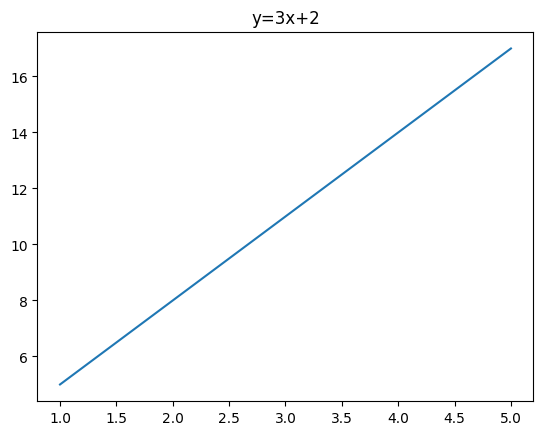

In [12]:
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.title('y=3x+2')
plt.show()

## 2-5) Sequential API
텐서플로 케라스는 세 가지 방식으로 모델을 생성할 수 있다. 
> Sequential API: 층을 이어 붙이듯 시퀀스에 맞게 일렬로 연결하는 방식으로 입력 레이어부터 출력 레이어까지 순스러르 갖는다.

입력데이터는 시퀀스의 가장 앞에 위치한 층에 투입되고 순서대로 각 층을 하나씩 통과하면서 딥러닝 연산을 수행한다. 

만약 2개 이상의 다중 입력이나 다중 출력을 갖는 복잡한 구조를 만들려면 Functional API를 사용해야한다.

### 2-5-1) 모델 구조

Sequential API를 사용한다면 두가지 방법으로 모델을 구성할 수 있다. 

리스트형 정의로 Sequential 클래스 함수에 파이썬 리스트 형태로 여러 개의 층을 입력한다. 대괄호 안에 쉼표로 구분하여 층을 쌓는다. 앞에 위치한 층부터 연산을 먼저 처리하고 순차적으로 다음 층의 연산을 수행하게 된다.



In [13]:
# Dense 레이어 3개를 갖는 모델을 생성
import tensorflow as tf

# 리스트형
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1)
])

다음은 add함수로 레이어 추가로 SEquential클래스 객체를 먼저 만든 뒤에, 생성된 모델 인스턴스에 층을 추가하는 방식이다.

In [14]:
# add 함수로 레이어 추가
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(5))
model.add(tf.keras.layers.Dense(1))

### 2-5-2) 입력 데이터 형태 

반드시 첫 번째 층은 input_Shape매개 변수를 지정해야한다!

In [15]:
import tensorflow as tf
model = tf.keras.Sequential([
    # 입력 데이터의 shape=(150,4)인 경우 input shape 지정
    tf.keras.layers.Dense(10, input_shape=[4]),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1)
])

-> (150,4) 형태라는 것은 150개의 샘플에 대하여 4개의 입력변수가 존재한다는 뜻이다.
각 행은 샘플 데이터를 나타내고 열은 입력변수를 나타낸다

### 2-5-3) 단순 선형회귀 모델 정의

단순 선형회귀 모델을 만들기 위해서는 1개의 뉴런을 가지는 Dense레이어 한 개를 사용한다. 

여기에 정의한 1개의 뉴런은 기울기에 해당하는 w와 상수항에 해당하는b를 매개변수로 갖는다. 

In [16]:
# 단순선형회귀 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1]) # 입력변수는 X 1개만 존재
])

-> 입력데이터는 x값 하나이므로 1로 설정하였고, 1개의 뉴런을 가지는 Dense레이어는 1개의 출력값을 가지므로 출력값은 y에 대한 모델의 예측값이다.

## 2-6) 모델 요약

모델을 만들었다면 model.summary()로 모델의 요약을 확인한다.

* 모델의 구조, 층별 노드의 개수가 표기된다. 
* 훈련시 업데이트할 파라미터의 개수가 표기된다.
* Total params는 모델 내부에 존재하는 모든 파라미터의 합계가 표기
* Trainable params는 모델 훈련 시 업데이트할 파라미터의 총 개수를 나타낸다.
* Non-trainable params는 훈련시 업데이트하지 않을 파라미터의 총 개수를 나타낸다.

단순선형회귀모델에서는 업데이트 파라미터가 가중치 w와 편향 b 두개이다. 

따라서 요약에서도 총 파라미터의 개수가 2개로 표기된다.

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## 2-7) 컴파일

컴파일 단계에서는 모델의 훈련과정에서 적용할 옵티마이저(obtimizer) , 손실함수(loss), 평가지표(metrics)를 정의한다. 

3가지 방법으로 지정할 수 있는데, 클래스 인스턴스 , 함수 혹은 사전 정의된 문자열이다.

* 클래스 인스턴스로 지정할 경우 학습률, 모멘텀 등의 하이퍼파라미터를 사용자가 직접 지정할 수 있다.

* 하지만 문자열로 지정하는 경우 기본값으로 설정된 하이퍼파라미터를 사용하며, 파라미터 수정은 어렵다는 한계가 있다. 

tip - 기본 설정만으로 딥러닝 모델의 성능이 잘 나오기 때문에 여기서는 문자열로 지정하는 방식을 주로 사용한다.



---


옵티마이저 : 확률적 경사하강법 알고리즘 'sgd'사용

손실 함수 : 평균제곱오차 (Mean Squared Error)

평가지표 : 평균 절대 오차 (Mean Absolute Error)

In [18]:
# 긴 문자열 지정
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])

# 짧은 문자열 지정
model.compile(optimizer='sgd', loss='mse', metrics=['mse', 'mae'])

# 클래스 인스턴스 지정
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics = [tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.MeanSquaredError()
                         ])

## 2-8) 훈련

모델을 훈련한다는 것은 가중치 텐서를 업데이트하는 과정을 말한다. 

fit()메소드에는 훈련용 데이터셋의 입력(x), 정답 출력(y), 반복 훈련할 epoch 수

매 epoch가 끝날 때마다 훈련 데이터셋에 대한 손실과 평가지표를 출력해줌

verbose = 0 옵션 지정 : 훈련 중간 과정 출력x



In [19]:
model.fit(x,y,epochs=5)

Epoch 1/5
1/1 [==============================] - 1s 588ms/step - loss: 9.2743 - mean_absolute_error: 9.2743 - mean_squared_error: 97.7721
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 9.1743 - mean_absolute_error: 9.1743 - mean_squared_error: 95.6380
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 9.0743 - mean_absolute_error: 9.0743 - mean_squared_error: 93.5276
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 8.9743 - mean_absolute_error: 8.9743 - mean_squared_error: 91.4408
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 8.8743 - mean_absolute_error: 8.8743 - mean_squared_error: 89.3776


5 epoch의 훈련이 끝난 뒤 손실함수는 19.9488, 평균절대오차 mae는 4.247를 기록함.

매 epoch당 loss값을 보면 171.6661에서 19.9488까지 모델의 예측 오차가 점점 줄어드는 것을 볼 수 있다. 

하지만 반복 훈련 횟수가 충분하지 않으므로 epoch를 늘려서 추가학습이 필요하다. 



---



epoch =1200로 설정하여 진행해보자. 

In [20]:
# 단순 선형회귀 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])
# 컴파일
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

# 훈련
history = model.fit(x,y,epochs=1200) #반환값 대입

Epoch 1/1200
1/1 [==============================] - 0s 327ms/step - loss: 172.6891 - mae: 12.2252
Epoch 2/1200
1/1 [==============================] - 0s 11ms/step - loss: 100.7065 - mae: 9.3711
Epoch 3/1200
1/1 [==============================] - 0s 12ms/step - loss: 58.7581 - mae: 7.1923
Epoch 4/1200
1/1 [==============================] - 0s 14ms/step - loss: 34.3122 - mae: 5.5289
Epoch 5/1200
1/1 [==============================] - 0s 12ms/step - loss: 20.0659 - mae: 4.2589
Epoch 6/1200
1/1 [==============================] - 0s 11ms/step - loss: 11.7633 - mae: 3.2893
Epoch 7/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.9246 - mae: 2.5490
Epoch 8/1200
1/1 [==============================] - 0s 10ms/step - loss: 4.1043 - mae: 1.9838
Epoch 9/1200
1/1 [==============================] - 0s 10ms/step - loss: 2.4603 - mae: 1.5521
Epoch 10/1200
1/1 [==============================] - 0s 10ms/step - loss: 1.5018 - mae: 1.2225
Epoch 11/1200
1/1 [==============================]

mse, mae모두 개선되었다. 

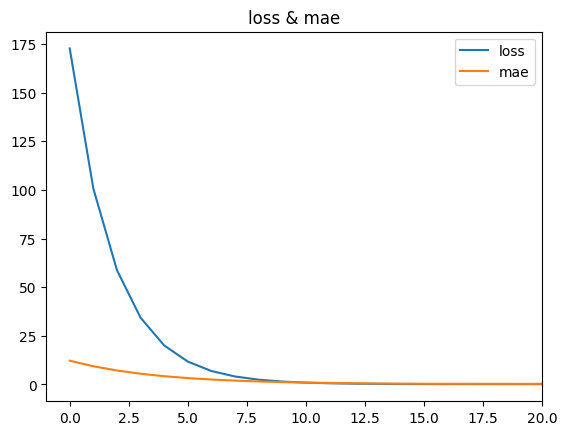

In [21]:
#epoch별 훈련 손실 및 평가지표 시각화

import matplotlib.pyplot as plt
# 20 epoch까지 Loss 수렴에 대한 시각화
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mae')
plt.xlim(-1, 20)
plt.title("loss & mae")
plt.legend()
plt.show()

첫 10epoch까지 손실이 급격히 감소하는 것을 확인할 수 있다.

그 이후는 감소 폭이 둔화되면서 조금씩 감소한다.

즉 모델 훈련 초기 단계에서는 학습이 매우 빨느 속도로 진행되다가 일정 epoch이후에 속도가 느려지는 패턴을 보인다.



---

## 2-9) 검증

evaluate() 메소드로 모델의 성능을 검증할 수 있다.

우리는 별도의 검증 셋을 만들어 두지 않아서 훈련 데이터셋의 x,y를 대입하여 반환되는 결과를 확인한다.


In [22]:
model.evaluate(x,y)

1/1 [==============================] - 0s 196ms/step - loss: 5.1666e-05 - mae: 0.0062


[5.166599294170737e-05, 0.006169510073959827]

위에서 1200번 epoch를 종료한 상태에서 출력값과 동일하다. 

그 이유는 검증 단계에서는 모델이 훈련을 마친 상태의 가중치를 그대로 적용하여 손실과 평가지표를 계산하기 때문이다.

\

** 사전에 별도의 검증 데이터셋을 준비하여 모델의 성능을 평가하는 것이 일반적인 방법이다. 

-> 별도의 데이터셋을 검증용으로 활용하는 방법: 교차검증

-> 교차검증 방법 : 홀드아웃, K-Fold교차검증 등이 있음.



---

## 2-10)예측 

predict()메소드에 새로운 입려 데이터를 넣어주면 예측 값을 얻을 수 있다.

괄호 안에 x 인자에 해당하는 값으로 숫자 10을 리스트 형태로 넣어준다. 

In [23]:
model.predict([10]) # y = 3*10+2 = 32

1/1 [==============================] - 0s 130ms/step


array([[32.029816]], dtype=float32)

꽤 근사한 값을 예측하였다.



---

# 3. 심층 신경망으로 이미지 분류

이미지분류는 단층이 아닌 더 깊은 층을 쌓아 깊이가 있는 딥러닝 모델을 생성한다. 

## 3-1) 데이터셋 로드

In [24]:
import tensorflow as tf
# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


훈련 셋 6만개, 검증 셋 만개 데이터가 저장

x_train에는 28x 28 크기의 정사각형 이미지 6만장이 저장되어 있다는 것!

In [25]:
print("train set: ", x_train.shape, y_train.shape)
print("test set: ", x_test.shape, y_test.shape)

train set:  (60000, 28, 28) (60000,)
test set:  (10000, 28, 28) (10000,)


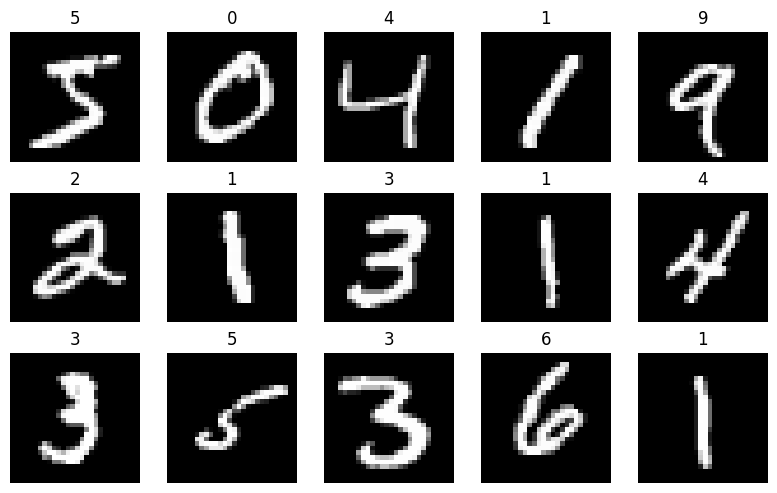

In [26]:
#처음 15장에 대한 이미지 시각화
# 데이터 시각화
import matplotlib.pyplot as plt

# canvas 생성
fig, axes = plt.subplots(3,5)
fig.set_size_inches(8,5)

for i in range(15):
  ax = axes[i//5, i%5]
  # imshow로 이미지 시각화
  ax.imshow(x_train[i], cmap='gray')
  ax.axis('off')
  ax.set_title(str(y_train[i]))

plt.tight_layout()
plt.show()

## 3-2) 데이터 전처리

1. 정규화를 통해 데이터 범위를 조절한다.
검증셋에도, test셋에도 정규화 동일 적용한다.

In [27]:
x_train[0, 10:15, 10:15] #배열의 각 원소는 이미지를 구성하는 하나의 픽셀 값과 일대일 대칭됨.

array([[  1, 154, 253,  90,   0],
       [  0, 139, 253, 190,   2],
       [  0,  11, 190, 253,  70],
       [  0,   0,  35, 241, 225],
       [  0,   0,   0,  81, 240]], dtype=uint8)

In [28]:
#정규화진행
# 픽셀 값의 최소/최대값 확인
print(f"정규화 전] 최소값: {x_train.min()}, 최대값: {x_train.max()}") # 0~255

# 데이터 정규화
x_train = x_train/x_train.max() 

# 정규화 후 최소/최대값 확인
print(f"정규화 후] 최소값: {x_train.min()}, 최대값: {x_train.max()}") # 0~1

# test set에도 정규화 동일 적용
x_test = x_test / x_test.max()

정규화 전] 최소값: 0, 최대값: 255
정규화 후] 최소값: 0.0, 최대값: 1.0


In [29]:
#변환 후 x_train 배열의 데이터 확인
x_train[0, 10:15, 10:15]

array([[0.00392157, 0.60392157, 0.99215686, 0.35294118, 0.        ],
       [0.        , 0.54509804, 0.99215686, 0.74509804, 0.00784314],
       [0.        , 0.04313725, 0.74509804, 0.99215686, 0.2745098 ],
       [0.        , 0.        , 0.1372549 , 0.94509804, 0.88235294],
       [0.        , 0.        , 0.        , 0.31764706, 0.94117647]])

정규화를 하는 이유 : 입력 데이터가 정규화 되어 모델이 학습하는 경우 경사하강법 알고리즘에 의한 수렴 속도가 빠름.

## 3-3) Flatten 레이어

정규화가 끝난 x_train의 shape는 (60000, 28,28) 로 변화가 없다. 

여기서, 2차원 입력은 Dense레이어에 입력값으로 넣을 수 없다.

In [30]:
#1차원으로 만들기
print(f"변경 전 shape: {x_train.shape}")
print(f"1D으로 shape 변경 후: {x_train.reshape(60000,-1).shape}")

변경 전 shape: (60000, 28, 28)
1D으로 shape 변경 후: (60000, 784)


Flatten 레이어를 사용하면 다차원을 1차원으로 펼쳐주는 방법도 가능하다. 

In [31]:
print(f"변경 전 shape: {x_train.shape}")
print(f"Flatten 적용 후: {tf.keras.layers.Flatten()(x_train).shape}")

변경 전 shape: (60000, 28, 28)
Flatten 적용 후: (60000, 784)


## 3-4) 활성화 함수

> 입력을 비선형 출력으로 변환해주는 함수

종류: 시그모이드, 하이퍼볼릭 탄젠트, ReLU, Leaky ReLU 등



In [32]:
#활성화 함수 적용시 ACTIVATION매개변수에 대입하면됨

# Dense layer에 relu 활성화 함수를 적용한 경우
tf.keras.layers.Dense(128, activation='relu')

별도의 층처럼 작용할 수 있다. 

In [33]:
# Dense 레이어와 relu 활성화 함수 레이어를 별도 적용한 경우 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu')
])

## 3-5) 입력과 출력

input_shape 매개변수를 지정한다. 

분류 모델의 가장 마지막 레이어는 출력층이다. 출력층의 노드 개수는 반드시 분류해야할 클래스 개수와 동일해야한다. 

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # 노드 = 10 (0~9)
    tf.keras.layers.Dense(10, activation='softmax')
])

조금씩 개수가 줄어드는 형태로 구성.
최적의 모델 형태를 위해서 레이어 개수와 노드의 개수가 중요한 하이퍼파라미터이다.

----
* 다중 분류 문제에서는 softmax활성화 함수를 사용해야한다. 
* 이진 분류 문제에서는 sigmoid 활성화 함수를 적용한다.

단, 이진 분류더라도 원핫ㅇ ㅣㄴ코딩으로 변환하여 노드 개수가 2개인 경우 softmax사용해야함.

In [35]:
# 출력층 노드 = 1 인 경우: sigmoid
tf.keras.layers.Dense(1, activation='sigmoid')
# 출력층 노드 = 2개 이상인 경우: softmax
tf.keras.layers.Dense(10, activation="softmax")

## 3-6 손실함수

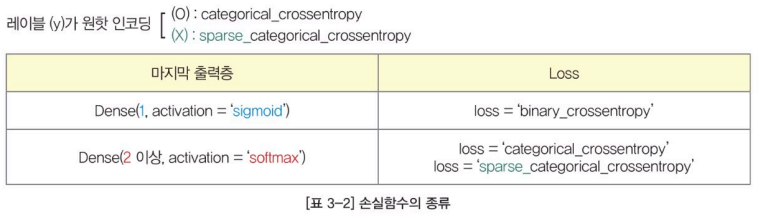

In [36]:
# 이진 분류(출력 노드 개수=1, sigmoid인 경우)
model.compile(loss="binary_crossentropy")

# y가 원핫 벡터인 경우 ex. [0.. 0.. 1.. 0..]
model.compile(loss="categorical_crossentropy")
# y가 원핫 벡터가 아닌 경우
model.compile(loss="sparse_categorical_crossentropy")

## 3-10) 옵티마이저

손실을 낮추기 위해서, 신경망의 가중치와 학습률 같은 신경망의 속성을 변경하는 데 사용되는 최적화 방법이다. 

* Adam이 일반적으로 많이 사용됨.

In [37]:
# 클래스 인스턴스로 지정
adam = tf.keras.optimizers.Adam(lr=0.001) #클래스 인스턴스로 지정할 때는 학습률 하이퍼파라미터 직접 설정 가능
model.compile(optimizer=adam)

# 문자열로 지정
model.compile(optimizer='adam') #소문자로 문자열 지정

## 3-8) 평가지표
* accuracy, auc, precision, recall등 많은 지표 사용됨.

평가지표도 옵티마이저와 마찬가지로 클래스 인스턴스로 지정하거나 문자열로 지정할 수 있다.

In [38]:
# 클래스 인스턴스로 지정
acc = tf.keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 문자열로 지정
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

## 3-9) 훈련



In [39]:
#훈련
model.fit(x_train, y_train, #검증셋 지정 
          validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2193 - accuracy: 0.9349 - val_loss: 0.1153 - val_accuracy: 0.9638
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0938 - accuracy: 0.9718 - val_loss: 0.0919 - val_accuracy: 0.9723
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0670 - accuracy: 0.9783 - val_loss: 0.0853 - val_accuracy: 0.9742
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0488 - accuracy: 0.9851 - val_loss: 0.0764 - val_accuracy: 0.9780
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0406 - accuracy: 0.9870 - val_loss: 0.0735 - val_accuracy: 0.9794
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0330 - accuracy: 0.9894 - val_loss: 0.0836 - val_accuracy: 0.9759
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0268 - accuracy: 0.9911 - val_loss: 0.0833 - val_ac

## 3-10) 평가

In [40]:
test_loss, test_auc = model.evaluate(x_test, y_test)
print("검증 셋 정확도: ", test_auc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0836 - accuracy: 0.9789
검증 셋 정확도:  0.9789000153541565


3-11) 예측

In [41]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [42]:
# 예측 결과
predictions[0]

array([8.1015327e-13, 1.1894914e-09, 8.4057881e-09, 8.8820812e-08,
       1.6838012e-10, 1.1258571e-09, 2.7843194e-12, 9.9999982e-01,
       1.4053345e-10, 3.1987231e-08], dtype=float32)

마지막 출력층의 노드 개수가 10개로 지정되었기 때문에 10개의 값이 출력된 것. 

In [43]:
import numpy as np
# 0번 index에 대한 예측 클래스 출력
print(np.argmax(predictions[0]))
# 첫 10개 index에 대한 예측 클래스 출력
print(np.argmax(predictions[:10], axis=1))

7
[7 2 1 0 4 1 4 9 6 9]


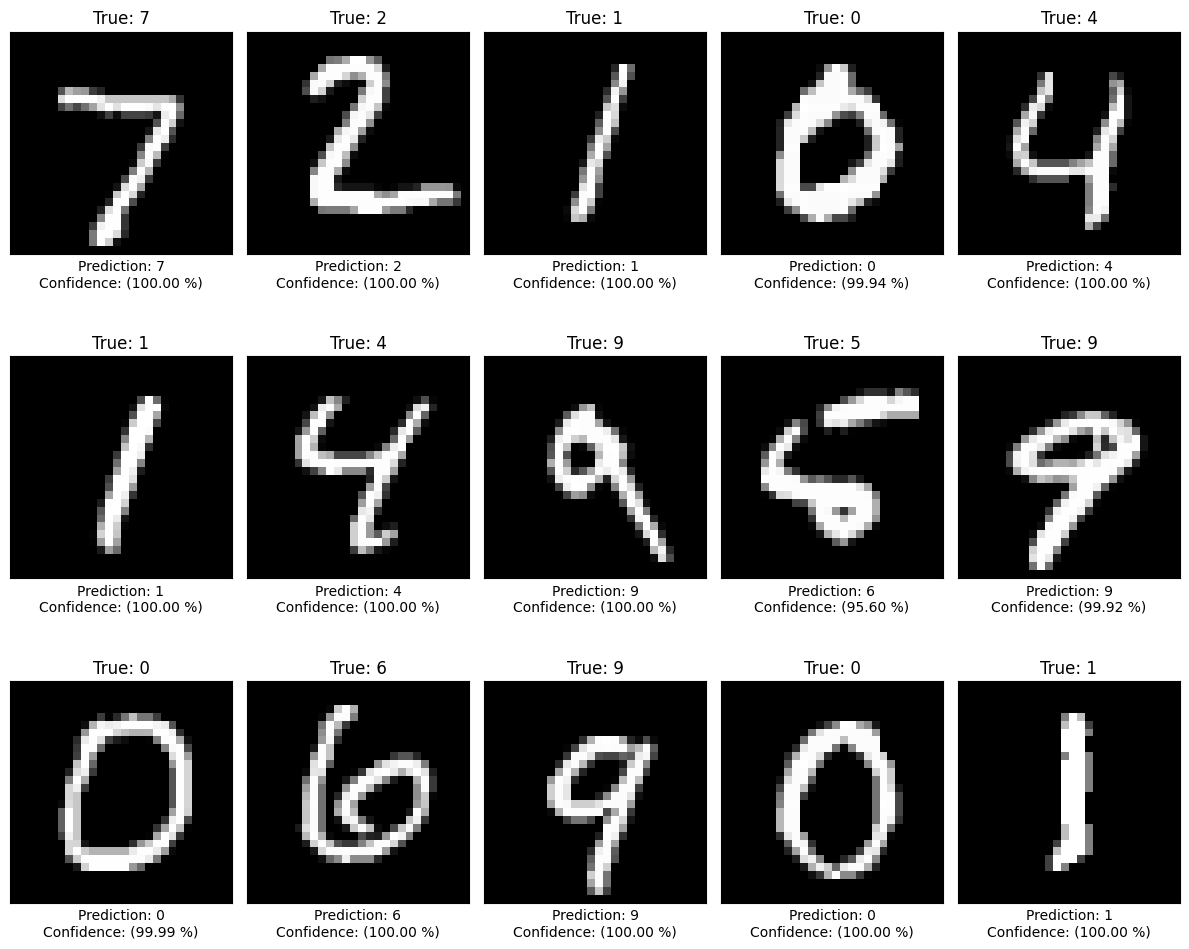

In [44]:
# 데이터 시각화
import matplotlib.pyplot as plt
def get_one_result(idx):
  img, y_true, y_pred, confidence = x_test[idx], y_test[idx], np.argmax(predictions[idx]), 100*np.max(predictions[idx])
  return img, y_true, y_pred, confidence

# canvas 생성
fig, axes = plt.subplots(3,5)
fig.set_size_inches(12,10)

for i in range(15):
  ax = axes[i//5, i%5]
  img, y_true, y_pred, confidence = get_one_result(i)

  # imshow로 이미지 시각화
  ax.imshow(img, cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f"True: {y_true}")
  ax.set_xlabel(f"Prediction: {y_pred}\nConfidence: ({confidence:.2f} %)")
plt.tight_layout()
plt.show()